# Task 05 - Non-parametric probability density estimation - Parzen window
## Pattern Recognition and Machine Learning

In [93]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook

from parzen import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as opt
import copy
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
data = np.load("data_33rpz_parzen.npz", allow_pickle=True)
tst = data["tst"].item()
trn = data["trn"].item()

## Tasks, bonus part

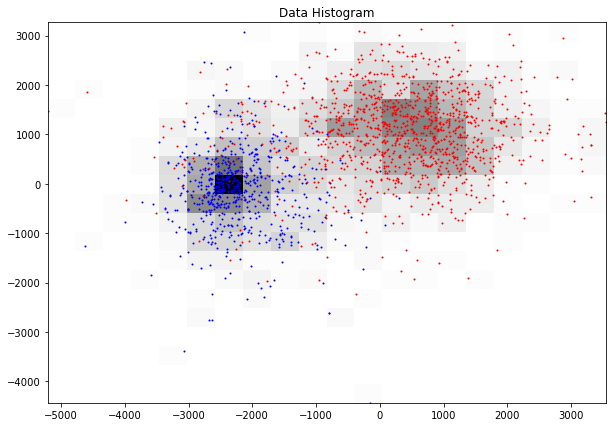

In [3]:
# image features
x = compute_measurement_lr_cont(trn['images'])
y = compute_measurement_ul_cont(trn['images'])

# splitting the trainning data into classes
idxs = np.squeeze(trn['labels'])
xA = x[idxs == 0]
xC = x[idxs == 1]
yA = y[idxs == 0]
yC = y[idxs == 1]

# show histogram
fig = plt.subplots(figsize =(10, 7))
plt.hist2d(x, y, bins=20, cmap='binary')
plt.plot(xA, yA, 'ro', markersize=1)
plt.plot(xC, yC, 'bo', markersize=1)
plt.title("Data Histogram")
plt.show()


In [74]:
axis_range = np.arange(-5000, 3000, 50)
h = [100., 500., 1000.]

p = np.zeros((len(h), axis_range.size, axis_range.size), np.float64)
for i in range(len(h)):
    print(h[i])
    p[i] = my_parzen_2d(axis_range, axis_range, xA, yA, h[i])

100.0
500.0
1000.0


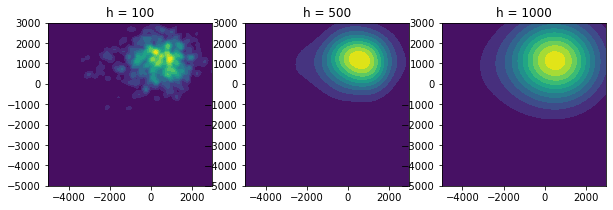

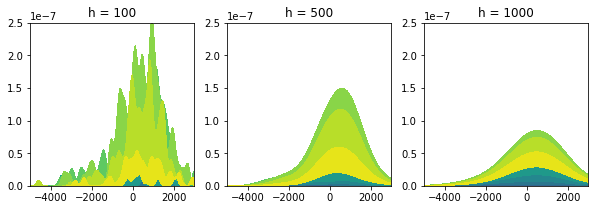

In [75]:
n_points = 160
X = np.linspace(-5000, 3000, n_points)
Y = np.linspace(-5000, 3000, n_points)
X, Y = np.meshgrid(X, Y)

plt.figure(figsize=(10,3))
for i in range(len(h)):
    plt.subplot(1, len(h), i+1)
    plt.contourf(X, Y, p[i], levels=13)
    plt.ylim(-5 * 1e+3, 3 * 1e+3)
    plt.title('h = {:.0f}'.format(h[i]))

plt.figure(figsize=(10,3))
for i in range(len(h)):
    plt.subplot(1, len(h), i+1)
    plt.contourf(X, p[i], Y, levels=13)
    plt.ylim(0, 2.5 * 1e-7)
    plt.title('h = {:.0f}'.format(h[i]))

#### class A cross-validation

In [76]:
h_range = np.linspace(100,1000,19)
num_folds = 10

In [78]:
np.random.seed(42)   # to get the same example outputs

num_data = xA.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.array([])
for cur_h in h_range:
    Lh = np.append(Lh, compute_Lh_2d(itrn, itst, xA, yA, cur_h))

In [79]:
h_bestA = opt.fminbound(lambda hh: -1 * compute_Lh_2d(itrn, itst, xA, yA, hh), 100, 1000)
Lh_bestA = compute_Lh_2d(itrn, itst, xA, yA, h_bestA)

Optimal h for A class is   355.1739959127758


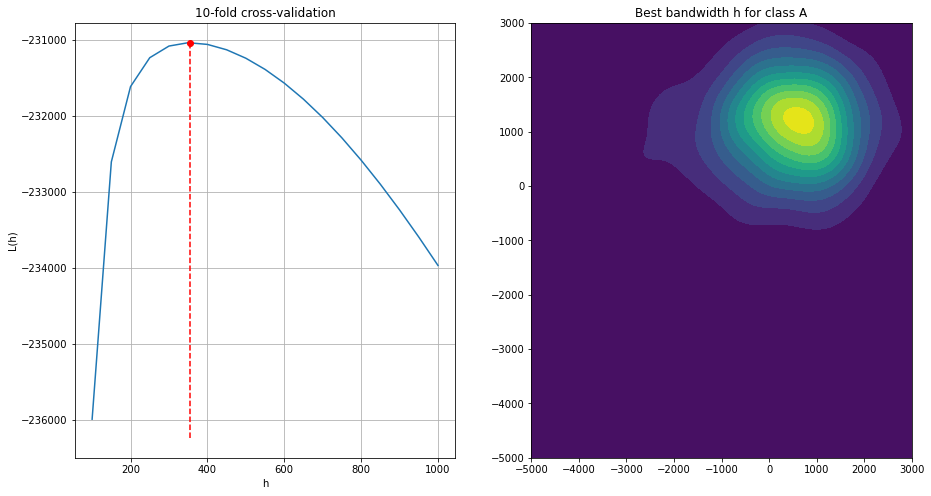

In [84]:
print('Optimal h for A class is  ', h_bestA)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestA, Lh_bestA, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestA, h_bestA], [bottom, Lh_bestA], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

p = my_parzen_2d(axis_range, axis_range, xA, yA, h_bestA)
plt.subplot(1,2,2)
plt.contourf(X, Y, p, levels=13)

plt.title('Best bandwidth h for class A')
plt.savefig('optimal_h_classA.png')

#### class C cross-validation

In [85]:
np.random.seed(42)   # to get the same example outputs

num_data = xC.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.zeros([h_range.size])
for h_iter in range(h_range.size):
    Lh[h_iter] = compute_Lh_2d(itrn, itst, xC, yC, float(h_range[h_iter]))

In [89]:
h_bestC = opt.fminbound(lambda hh: -1 * compute_Lh_2d(itrn, itst, xC, yC, hh), 100, 1000)
Lh_bestC = compute_Lh_2d(itrn, itst, xC, yC, h_bestC)

Optimal h for C class is   322.99320950717026


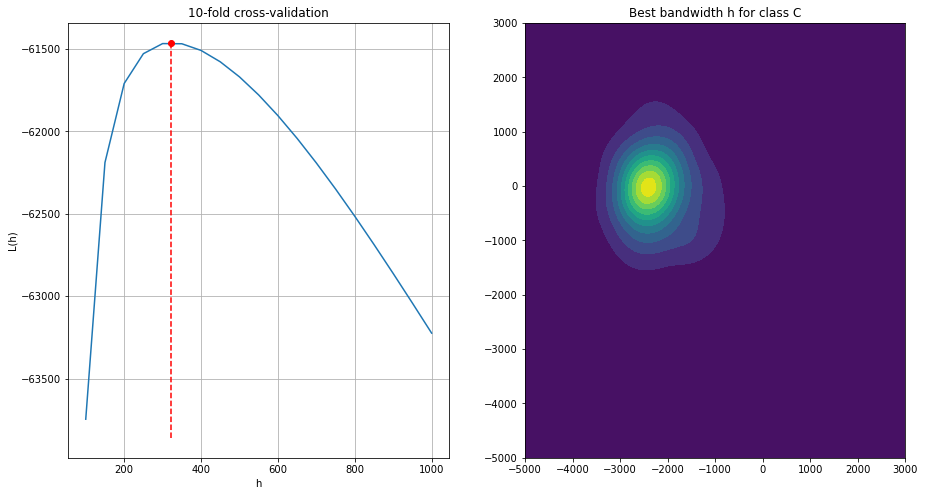

In [91]:
print('Optimal h for C class is  ', h_bestC)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestC, Lh_bestC, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestC, h_bestC], [bottom, Lh_bestC], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

p = my_parzen_2d(axis_range, axis_range, xC, yC, h_bestC)
plt.subplot(1,2,2)
plt.contourf(X, Y, p, levels=13)

plt.title('Best bandwidth h for class C')
plt.savefig('optimal_h_classC.png')

## Bayesian classifier

In [96]:
x_test = compute_measurement_lr_cont(tst['images'])
y_test = compute_measurement_ul_cont(tst['images'])

# computing a priori probabilities
n_A = np.size(xA)
n_C = np.size(xC)
pA = n_A/(n_A + n_C)
pC = n_C/(n_A + n_C)
labels = classify_bayes_parzen_2d(x_test, y_test, xA, xC, yA, yC, pA, pC, h_bestA, h_bestC)

#### visualisation

Classification error = 5.5%


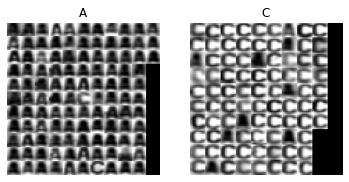

In [100]:
show_classification(tst['images'], labels, 'AC')
plt.savefig('parzen_classif.png')

# classification error
bayes_error = float(np.sum(labels != tst['labels']) / np.size(labels))
print('Classification error = {:.1f}%'.format(bayes_error * 100))